# ffp

> A module to model and calculate the properties of Free Floating Planets (FFPs), such as density, mass, distance, and velocity distribution.

In [ ]:
#| default_exp ffp

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad, dblquad
from scipy.interpolate import interp1d, interp2d
import pickle
import functools
from pathos.multiprocessing import ProcessingPool as Pool


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export

# Disk Density
def zthin(r):
    if r > 4.5:
        return zthinSol - (zthinSol - zthin45) * (rsol - r) / (rsol - 4.5)
    else:
        return zthin45

def rho_thin_mw(r, 
             z,
            n_ffp: float = 1, # number of FFPs per star
            m_low: float = 1e-6, # mass of FFP in Msun
            alpha: float = 2, # power law index of FFP mass function):
            ) -> float: # FFP density in Msun/kpc^3
    #? Is averaging over mass correct here?
    mass_avg = m_avg_interp(m_low, alpha)

    if r > rdBreak:
        result = rho_thin_Sol * zthinSol / zthin(r) * \
            np.exp(-((r - rsol) / rthin)) * (1 / np.cos(np.abs(z) / zthin(r)))**2
    else:
        result = rho_thin_Sol * zthinSol / zthin(r) * \
            np.exp(-((rdBreak - rsol) / rthin)) * (1 / np.cos(np.abs(z) / zthin(r)))**2
    
    return result * n_ffp * mass_avg

def rho_thick_mw(r, 
              z, 
            n_ffp: float = 1, # number of FFPs per star
            m_low: float = 1e-6, # mass of FFP in Msun
            alpha: float = 2, # power law index of FFP mass function):
            ) -> float: # FFP density in Msun/kpc^3
    #? Is averaging over mass correct here?
    mass_avg = m_avg_interp(m_low, alpha)
    
    if r > rdBreak:
        result = rho_thick_Sol * np.exp(-((r - rsol) / rthick)) * \
            np.exp(-(np.abs(z) / zthickSol))
    else:
        result = rho_thick_Sol * np.exp(-((rdBreak - rsol) / rthick)) * \
            np.exp(-(np.abs(z) / zthickSol))

    return result * n_ffp * mass_avg

# Bulge Density
def rsf(xp, yp, zp):
    R = (xp**cperp / x0**cperp + yp**cperp / y0**cperp)**(cpar/cperp) + (zp / z0)**cpar
    return R**(1/cpar)

def fE(xp, yp, zp):
    return np.exp(-rsf(xp, yp, zp))

def cut(x):
    if x > 0:
        return np.exp(-x**2)
    else:
        return 1

def rho_bulge_mw(d: float,
            n_ffp: float = 1, # number of FFPs per star
            m_low: float = 1e-6, # mass of FFP in Msun
            alpha: float = 2, # power law index of FFP mass function):
            ) -> float: # FFP density in Msun/kpc^3
    #? Is averaging over mass correct here?
    mass_avg = m_avg_interp(m_low, alpha)
    xp, yp = get_primed_coords(d)
    #todo need to generalize this to arbitrary z
    zp = 0
    R = (xp**2 + yp**2 + zp**2)**0.5
    return rho0_B * fE(xp, yp, zp) * cut((R - Rc) / 0.5) * n_ffp * mass_avg

# Total FFP Density
def rho_FFPs_mw(d: float, # distance from Sun in kpc
             n_ffp: float = 1, # number of FFPs per star
             m_low: float = 1e-6, # lowest mass of FFP in Msun
             alpha: float = 2, # power law index of FFP mass function
             ) -> float: # FFP density in Msun/kpc^3
    r = dist_mw(d)
    z = 0
    return (rho_thin_mw(r, z, n_ffp, m_low, alpha) + rho_thick_mw(r, z, n_ffp, m_low, alpha ) + rho_bulge_mw(d, n_ffp, m_low, alpha)) 

def m_avg_ffp(m_low, alpha):
    masses = m_low * (1 - np.random.rand(int(1e4)))**(-1 / (alpha - 1))
    masses[masses > m_high_interp] = m_high_interp
    return np.mean(masses)

m_low_ffp_interp = 1e-15
m_high_interp = 1e0
alpha_low_interp = 1
alpha_high_interp = 3

def make_m_avg_interp(n_points=40):
    alpha_arr = np.linspace(alpha_low_interp, alpha_high_interp, n_points)
    m_arr = np.logspace(np.log10(m_low_interp), np.log10(m_high_interp), n_points) #solar masses

    def calc_m_avg_arr(m):
    # Calculate ut_arr for the current m
        return np.array([m_avg_ffp(m, alpha) for alpha in alpha_arr])
    
    with Pool() as p:
        m_avg_values = list(p.map(calc_m_avg_arr, m_arr))

    # Convert ut_values to a 2D array
    m_avg_values = np.array(m_avg_values)
    
    # Create the 2D interpolation table
    m_avg_interp = interp2d(m_arr, alpha_arr, m_avg_values)
    return m_avg_interp

In [ ]:
#| export
# Add stellar distribution of M31 following: https://www.aanda.org/articles/aa/pdf/2012/10/aa20065-12.pdf

def einasto(a, rhoc, dn, ac, n):
    return rhoc * np.exp(-dn *((a/ac)**(1/n) - 1))

def rho_bulge_m31(a, 
                m_low: float = 1e-6, # mass of FFP in Msun
                alpha: float = 2, # power law index of FFP mass function):
                ) -> float: # FFP density in Msun/kpc^3
    mass_avg = m_avg_interp(m_low, alpha)

    rhoc = 9.201e-1 * (1e3)**3 #Msun/kpc^3
    dn = 7.769
    ac = 1.155 #kpc
    n = 2.7
    return einasto(a, rhoc, n, ac, dn) * mass_avg

def rho_disk_m31(a,
                 m_low: float = 1e-6, # mass of FFP in Msun
                 alpha: float = 2, # power law index of FFP mass function
                    ) -> float: # FFP density in Msun/kpc^3
    mass_avg = m_avg_interp(m_low, alpha)
    rhoc = 1.307e-2 * (1e3)**3 #Msun/kpc^3
    dn = 3.273
    ac = 10.67 #kpc
    n = 1.2
    return einasto(a, rhoc, n, ac, dn) * mass_avg

def rho_nucleus_m31(a,
                    m_low: float = 1e-6, # mass of FFP in Msun
                    alpha: float = 2, # power law index of FFP mass function
                    ) -> float: # FFP density in Msun/kpc^3
    mass_avg = m_avg_interp(m_low, alpha)
    rhoc = 1.713 * (1e3)**3 #Msun/kpc^3
    dn = 11.668
    ac = 0.0234 #kpc
    n = 4.0
    return einasto(a, rhoc, n, ac, dn) * mass_avg


def rho_FFPs_m31(a: float, # distance from center of M31 in kpc
             n_ffp: float = 1, # number of FFPs per star
             m_low: float = 1e-6, # lowest mass of FFP in Msun
             alpha: float = 2, # power law index of FFP mass function
             ) -> float: # FFP density in Msun/kpc^3
    return (rho_bulge_m31(a, m_low, alpha) + rho_disk_m31(a, m_low, alpha) + rho_nucleus_m31(a, m_low, alpha)) * n_ffp

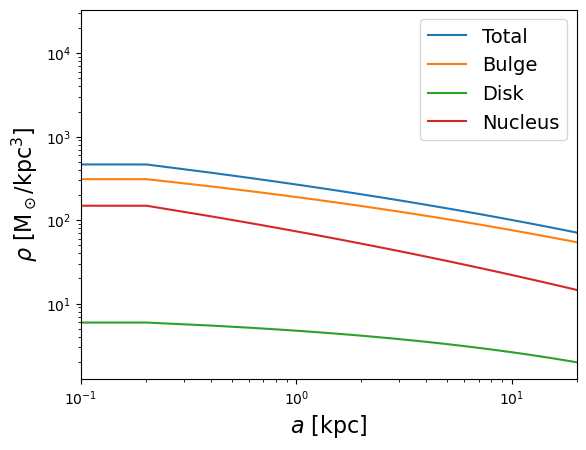

In [ ]:
# Define values for the x-axis
a = np.linspace(0, 20, num=100)
z = 0
# Calculate the density values for each component
rho_total_arr = [rho_FFPs_m31(i) for i in a]
rho_bulge_arr = [rho_bulge_m31(i) for i in a]
rho_disk_arr = [rho_disk_m31(i) for i in a]
rho_nucleus_arr = [rho_nucleus_m31(i) for i in a]

# Create the log plot
plt.plot(a, rho_total_arr, label="Total")
plt.plot(a, rho_bulge_arr, label="Bulge")
plt.plot(a, rho_disk_arr, label="Disk")
plt.plot(a, rho_nucleus_arr, label="Nucleus")

# Add labels and legend
plt.xlabel(r"$a$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.legend(fontsize=14)

plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-1, 20)
# plt.ylim(1e-3, 1e7)

# Show the plot
plt.show()

In [ ]:
#| hide
# m_avg_interp = make_m_avg_interp(n_points=40)
# with open('../interpolations/m_avg_interp.pkl', 'wb') as f:
#     pickle.dump(m_avg_interp, f)

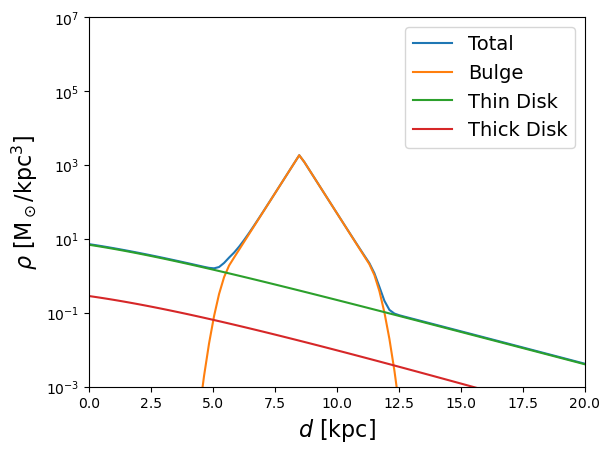

In [ ]:
# Define values for the x-axis
d = np.linspace(0, 20, num=100)
z = 0
# Calculate the density values for each component
rho_total_arr = [rho_FFPs_mw(i) for i in d]
rho_bulge_arr = [rho_bulge_mw(i) for i in d]
rho_thin_arr = [rho_thin_mw(dist_mw(i), z) for i in d]
rho_thick_arr = [rho_thick_mw(dist_mw(i), z) for i in d]

# Create the log plot
plt.plot(d, rho_total_arr, label="Total")
plt.plot(d, rho_bulge_arr, label="Bulge")
plt.plot(d, rho_thin_arr, label="Thin Disk")
plt.plot(d, rho_thick_arr, label="Thick Disk")

# Add labels and legend
plt.xlabel(r"$d$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.legend(fontsize=14)

plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(1e-3, 1e7)

# Show the plot
plt.show()


In [ ]:
#| export
class Ffp(Lens):
    """A class to represent a PBH population"""

    def __init__(self,
                mass: float, # FFP mass in solar masses
                ):
        """
        Initialize the PBH population
        """
        if mass < m_low_interp or mass > m_high_interp:
            raise ValueError("mass must be between 1e-16 and 1e-4 or a different interpolation function must be used for u_t")
        self.mass = mass
        self.ut_interp = ut_interp
    
    def __str__(self) -> str:
        return f"FFP with m_ffp={self.mass}"
    __repr__ = __str__

    def differential_rate_integrand_mw(self, umin, d, t, finite=False):
        return self.differential_rate_integrand(umin, d, t, dist_mw, rho_FFPs_mw, velocity_dispersion_mw, finite=finite, density_func_uses_d=True)

    def differential_rate_mw(self, t, finite=False):
        return self.differential_rate(t, self.differential_rate_integrand_mw, finite=finite)
    
    def differential_rate_integrand_m31(self, umin, d, t, finite=False):
        return self.differential_rate_integrand(umin, d, t, dist_m31, rho_FFPs_m31, velocity_dispersion_m31, finite=finite, density_func_uses_d=False)
    
    def differential_rate_m31(self, t, finite=False):
        return self.differential_rate(t, self.differential_rate_integrand_m31, finite=finite)

    def umin_upper_bound(self, d):
        if self.ut_interp is None:
            self.make_ut_interp()
        return self.ut_interp(d, self.mass)[0]
    
    def differential_rate_total(self, t, finite=False):
        return self.differential_rate_mw(t, finite=finite) + self.differential_rate_m31(t, finite=finite)
 
    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]

In [ ]:
f = Ffp(1e-12)

In [ ]:
print(f.differential_rate_mw(1, finite=False))
print(f.differential_rate_mw(1, finite=True))
print(f.differential_rate_m31(1, finite=False))
print(f.differential_rate_m31(1, finite=True))

9.339086266781257e-19
6.884041631197048e-19
4.2474235795462e-13
1.3750126094033772e-17


## Perform Weighted Sum over FFP distribution

In [ ]:
#| export
class FfpPopulation():
    
    def __init__(self, 
                 mlow: float, # lower mass limit in solar masses
                 alpha: float, # power law slope of distribution
                 n_bins: int = 10, # number of bins to use for the mass distribution
                 ): 
        if alpha < alpha_low_interp or alpha > alpha_high_interp:
            raise ValueError(f"alpha must be between {alpha_low_interp} and {alpha_high_interp}")
        if mlow < m_low_ffp_interp or mlow > m_high_interp:
            raise ValueError(f"mlow must be between {m_low_ffp_interp} and {m_high_interp}")
        self.mlow = mlow
        self.alpha = alpha
        self.sample_masses = self.generate_sample(int(1e4))
        self.tE_interp = None
        self.tE_finite_interp = None
        self.ut_interp = ut_interp
        self.n_bins = n_bins
        self.ffps = []
        self.ffp_weights = [] #relative contribution of each FFP mass bin

        self.generate_ffps()
    
    def __str__(self):
        return f"FFP: mlow={self.mlow}, alpha={self.alpha}, n_bins={self.n_bins}"
    __repr__ = __str__

    def generate_ffps(self):
        bins = np.logspace(np.log10(self.mlow), np.log10(np.max(self.sample_masses) * 1.01), num=self.n_bins)
        counts, hist_bins, = np.histogram(self.sample_masses, bins=bins, density=True)
        bin_centers = (hist_bins[1:] + hist_bins[:-1]) / 2
        weights = counts/np.sum(counts)
        masses = bin_centers
        for mass in masses:
            self.ffps.append(Ffp(mass))
        for weight in weights:
            self.ffp_weights.append(weight)

    def get_weighted_te(self,
                        finite=False,
                        ):
        tMin = 1e-2  # hours
        tMax = 1e3
        n_t_bins = 10
        tBins = np.logspace(np.log10(tMin), np.log10(tMax), num=n_t_bins)

        tETable = np.zeros((len(self.ffps)-1, len(tBins)))
        for i in range(len(self.ffps)-1):
            for j in range(len(tBins)):
                tETable[i,j] = self.ffp_weights[i] * self.ffps[i].differential_rate_total(tBins[j], finite=finite)

        tEWeighted = np.sum(tETable, axis=0)
        return tBins, tEWeighted

    def generate_sample(self, 
                        n: int = int(1e4) # number of samples
                        ):
        masses = self.mlow * (1 - np.random.rand(int(n)))**(-1 / (self.alpha - 1))
        masses[masses > m_high_interp] = m_high_interp
        return masses

    def make_te_interp(self,
                       finite = False,
                       ):
        tBins, tEWeighted = self.get_weighted_te(finite=finite)
        # Handle zero values in tEWeighted
        eps = 1e-50
        tEWeighted_nonzero = np.where(tEWeighted == 0, eps, tEWeighted)
        tEInterp = interp1d(np.log10(tBins), np.log10(tEWeighted_nonzero), kind="cubic")

        if finite:
            self.tE_finite_interp = tEInterp
        else:
            self.tE_interp = tEInterp

    def differential_rate_total(self, t, finite=False):
        if finite:
            if self.tE_finite_interp is None:
                self.make_te_interp(finite=finite)
            return 10**self.tE_finite_interp(np.log10(t))
    
        if self.tE_interp is None:
            self.make_te_interp(finite=finite)
        return 10**self.tE_interp(np.log10(t))

    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]

In [ ]:
mMin = 1e-12  # solar masses
alpha = 2
fp = FfpPopulation(mMin, alpha)
fp

FFP: mlow=1e-12, alpha=2, n_bins=10

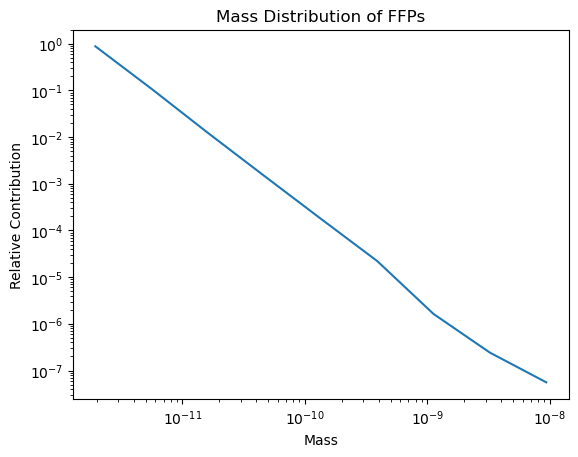

In [ ]:
plt.loglog([ffp.mass for ffp in fp.ffps], fp.ffp_weights)
plt.xlabel("Mass")
plt.ylabel("Relative Contribution")
plt.title("Mass Distribution of FFPs")
plt.show()

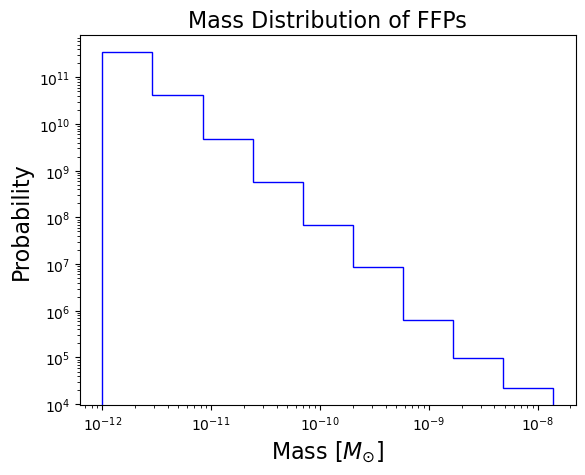

In [ ]:
nBins = 10
tMin = 1e-2  # hours
tMax = 1e3
ntBins = 10

fp.generate_sample(n=1e4)
mSample = fp.sample_masses
tBins = np.logspace(np.log10(tMin), np.log10(tMax), num=ntBins)
bins = np.logspace(np.log10(mMin), np.log10(np.max(mSample) * 1.01), num=nBins)
hist, bins = np.histogram(mSample, bins=bins, density=True)

plt.hist(mSample, bins=bins, density=True, histtype="step", color="blue")

plt.xlabel("Mass [$M_{\odot}$]", fontsize=16)
plt.ylabel("Probability", fontsize=16)
plt.title("Mass Distribution of FFPs", fontsize=16)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
ts = np.logspace(-2, np.log10(1e3), num=100)
diff_rates = fp.compute_differential_rate(ts, finite=False)
diff_rates_finite = fp.compute_differential_rate(ts, finite=True)

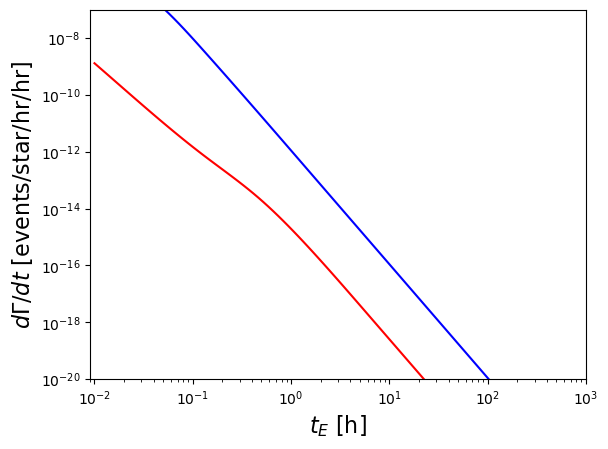

In [ ]:
plt.loglog(ts, diff_rates, color="blue")
plt.loglog(ts, diff_rates_finite, color="red")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.xlim([0.009, 1e3])
plt.ylim([1e-20, 1e-7])
plt.show()

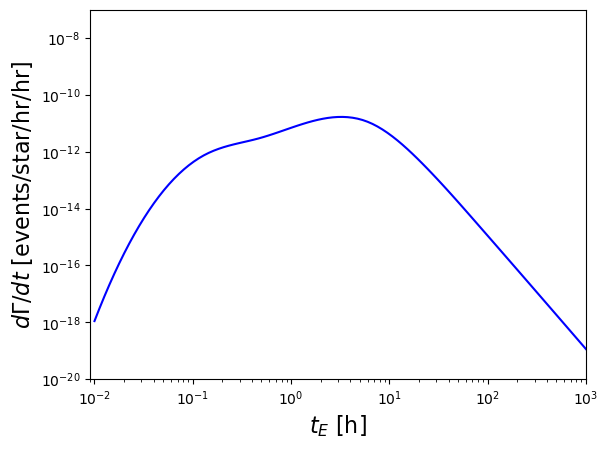

In [ ]:
#this is with m31 contribution
ts = np.logspace(-2, np.log10(1e3), num=100)
diff_rates = fp.compute_differential_rate(ts, finite=False)

plt.loglog(ts, diff_rates, color="blue")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.xlim([0.009, 1e3])
plt.ylim([1e-20, 1e-7])
plt.show()

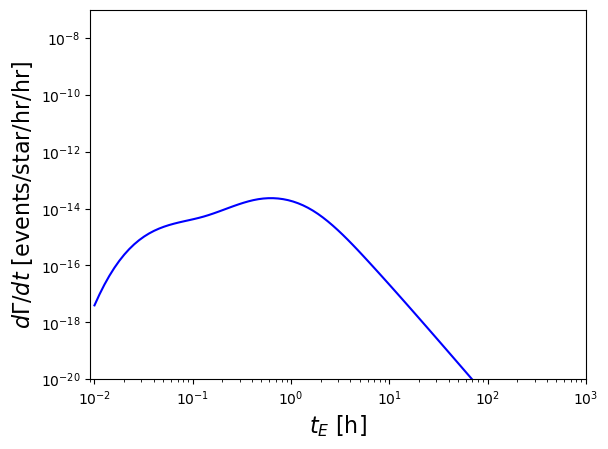

In [ ]:
#this is just mw
ts = np.logspace(-2, np.log10(1e3), num=100)
diff_rates = fp.compute_differential_rate(ts, finite=False)

plt.loglog(ts, diff_rates, color="blue")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.xlim([0.009, 1e3])
plt.ylim([1e-20, 1e-7])
plt.show()

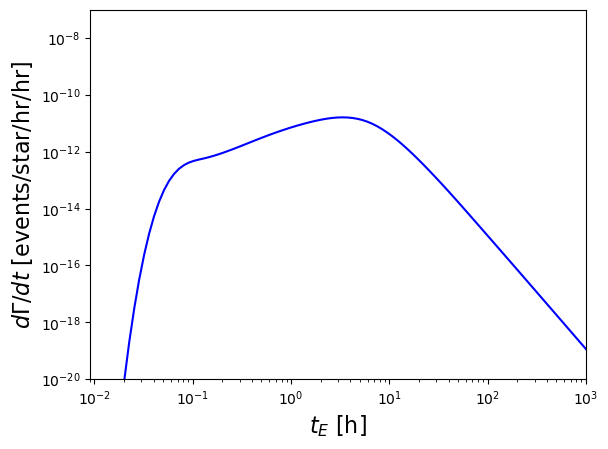

In [ ]:
#This is with m31 contribution
diff_rates_finite = fp.compute_differential_rate(ts, finite=True)
plt.loglog(ts, diff_rates_finite, color="blue")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.xlim([0.009, 1e3])
plt.ylim([1e-20, 1e-7])
plt.show()

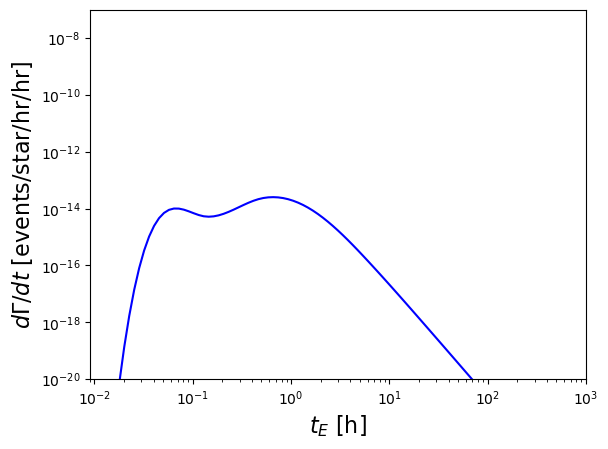

In [ ]:
#this is just mw
diff_rates_finite = fp.compute_differential_rate(ts, finite=True)
plt.loglog(ts, diff_rates_finite, color="blue")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.xlim([0.009, 1e3])
plt.ylim([1e-20, 1e-7])
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()